# Imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

# Dataset Creation

In [2]:
features_cols = ['X','Y']
label_col = 'LABEL'
index_col = 'ID'
size = 10000
min_value = 0
max_value = 1000

points = [['ID{}'.format(i), np.random.randint(min_value,max_value), 
           np.random.randint(min_value,max_value)] for i in range(size)]

labeled_df = pd.DataFrame(points, columns=[index_col, 'X','Y'])
labeled_df[label_col] = labeled_df.apply(lambda row: 'HIGH' if row['X'] < row['Y'] else 'LOW', axis=1)

labeled_df

,ID,X,Y,LABEL
0,ID0,637,700,HIGH
1,ID1,24,133,HIGH
2,ID2,839,691,LOW
3,ID3,410,395,LOW
4,ID4,421,954,HIGH
...,...,...,...,...
9995,ID9995,683,595,LOW
9996,ID9996,54,812,HIGH
9997,ID9997,785,863,HIGH
9998,ID9998,492,223,LOW


In [10]:
from sklearn.datasets import make_classification

# define dataset
features_cols = ['X','Y']
label_col = 'LABEL'
index_col = 'ID'
samples = 5000
X, y = make_classification(n_samples=samples, n_features=10, n_informative=5, n_redundant=5, n_classes=5, random_state=1)

labeled_df = pd.DataFrame(X)
labeled_df[label_col] = y
labeled_df[index_col] = ['ID{}'.format(i) for i in range(samples)]

labeled_df

,0,1,2,3,4,5,6,7,8,9,LABEL,ID
0,3.272161,-0.531274,1.411176,0.084889,-1.524650,3.334609,0.729821,-1.878625,-1.136122,3.091356,3,ID0
1,4.202404,-2.126434,4.483380,4.766652,-1.163170,-0.280453,-6.420369,-1.168316,-2.817256,2.738822,3,ID1
2,3.834663,-3.054396,4.428851,4.686023,0.573630,0.148688,-3.847525,-2.943846,2.683860,-0.566324,4,ID2
3,2.974835,0.243415,-0.208499,0.683675,1.779841,0.119911,-0.562123,-2.256594,1.917021,-1.455035,4,ID3
4,9.373935,0.897580,0.669649,2.647999,3.945295,2.707463,0.002950,-2.396834,-0.166069,1.082600,1,ID4
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-3.269150,-1.485074,1.296507,1.372354,0.076896,-1.786523,-0.493312,1.921974,1.376929,-1.449845,2,ID4995
4996,0.991417,0.752488,-0.965029,0.525300,1.091980,-2.846009,-4.017736,-1.963629,0.686093,-2.485908,1,ID4996
4997,3.094766,-0.558664,1.452302,0.431939,-1.235198,2.733004,0.176271,-1.646633,-1.091050,2.693968,3,ID4997
4998,-2.585142,-0.004109,-0.153988,-0.274134,-0.790521,-1.185929,-0.422569,1.844458,-1.190473,0.165572,4,ID4998


# Modeling & Training

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from automl_infrastructure.classifiers.adapters import SklearnClassifierAdapter

lr_model = SklearnClassifierAdapter(name='lr', sklearn_model=LogisticRegression())
rf_model = SklearnClassifierAdapter(name='rf', sklearn_model=RandomForestClassifier())

# Active Learning Declaration

In [12]:
from automl_infrastructure.experiment import Experiment
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import scipy.stats


def entropy_strategy(proba):
    return scipy.stats.entropy(proba)

def least_confidence_strategy(proba):
    return 1 - np.amax(proba)

def random_strategy(proba):
    return np.random.uniform()


class ActiveLearningRecommender(object):
    
    def __init__(self, strategy):
        self._strategy = strategy
    
    def query(self, model, unlabeled_df, index_col, output_score_col='SCORE'):
        # predict proba for each instance
        unlabeled_predictions_proba = model.predict_proba(unlabeled_df.drop(index_col, axis=1))
        
        # transform proba to score based on strategy
        unlabeled_scores = [self._strategy(proba) for proba in unlabeled_predictions_proba]
        
        instances_scores = unlabeled_df[[index_col]].copy()
        instances_scores[output_score_col] = unlabeled_scores
        return instances_scores.sort_values(by=[output_score_col], ascending=False)
    

class ActiveLearningEvaluator(object):
    
    def __init__(self, model, gt, index_col, label_col, scoring='accuracy'):
        self._model = copy.deepcopy(model)
        self._gt = gt
        self._index_col = index_col
        self._label_col = label_col
        self._scoring = scoring
        self._features_columns = [c for c in gt.columns if c not in (label_col, index_col)]
        
        # evaluation data
        self._recommenders_scores = None
        self._recommenders_lst = None
    
    
    def _recommender_test_instances_split(self, train, test, recommender, top_instances):
        # verify required top instances is not higher then the test set
        if top_instances > test.shape[0]:
            raise Exception('Number of selected instances must not be higher than test set size.')
            
        # train model and recommend instances from test
        self._model.fit(train[self._features_columns], train[label_col])
        instances_ids_df = recommender.query(self._model, test.drop(self._label_col, axis=1), self._index_col)\
                                    .head(top_instances)[[self._index_col]]
        instances_df = pd.merge(instances_ids_df, test, on=[self._index_col])
        
        # remove instances from test
        effective_test = test[test[self._index_col].isin(instances_df[self._index_col]) == False]
        
        return instances_df, effective_test
    
    def _score_instances_recommender(self, train, test, n_folds, n_repeats, recommender, top_instances):
        instances_df, effective_test = self._recommender_test_instances_split(train, test, recommender, top_instances)
        
        # run k-fold scoring on test set
        e = Experiment('e', effective_test[self._features_columns], effective_test[self._label_col], 
                models=[self._model], objective=self._scoring, n_folds=n_folds, n_repetitions=n_repeats, 
                additional_training_data_x=instances_df[self._features_columns],
                additional_training_data_y=instances_df[self._label_col])
        e.run()
        
        return e.objective_score(model_name=self._model.name, group='test')
    
    def evaluate(self, gt_ratios, recommenders, iters=10, test_ratio=0.5, n_folds=4, kfold_n_repeats=3, top_instances=10):
        gt_ratios = sorted(gt_ratios)
        recommenders_scores = {}
        for gt_ratio in gt_ratios:
            recommenders_scores[gt_ratio] = {}
            # initialize recommenders scores list
            for recommender_name in recommenders:
                recommenders_scores[gt_ratio][recommender_name] = []
                
            for i in range(iters):
                # split sample gt and split to train and test
                sampled_gt = self._gt.sample(frac=gt_ratio)
                train, test = train_test_split(sampled_gt, train_size=1-test_ratio, test_size=test_ratio,
                                               stratify=sampled_gt[self._label_col])
                # calculate score for each recommender
                for recommender_name, recommender in recommenders.items():
                    recommender_score = self._score_instances_recommender(train, test, n_folds=n_folds,
                                    n_repeats=kfold_n_repeats, recommender=recommender, top_instances=top_instances)
                    recommenders_scores[gt_ratio][recommender_name].append(recommender_score)
        self._recommenders_scores = recommenders_scores
        self._recommenders_lst = [r for r in recommenders]
    
    def plot(self, min_score=0.0, max_score=1.05, figsize=(5,5)):
        if self._recommenders_scores is None:
            raise Exception('You was evaluate before plotting')
        
        # create xs ticks
        xs = [int(gt_ratio*self._gt.shape[0]) for gt_ratio in self._recommenders_scores]
        plt.clf()
        plt.figure(figsize=figsize)
        for recommender_name in self._recommenders_lst:
            ys = []
            for gt_ratio in self._recommenders_scores:
                ys.append(np.mean(self._recommenders_scores[gt_ratio][recommender_name]))
            plt.plot(xs, ys, label=recommender_name)
            
        plt.xlabel('GT Size')
        plt.ylabel('Score')
        plt.xlim([0, self._gt.shape[0]])
        plt.ylim([min_score, max_score])
        plt.title('Recommenders Performence')
        plt.legend(loc='upper right')
        

# Define Recommenders & Evaluate

In [13]:
# define recommenders
entropy_recommender = ActiveLearningRecommender(entropy_strategy)
lc_recommender = ActiveLearningRecommender(least_confidence_strategy)
random_recommender = ActiveLearningRecommender(random_strategy)

# define evaluator
evaluator = ActiveLearningEvaluator(lr_model, labeled_df, index_col, label_col, scoring='precision')
evaluator.evaluate(gt_ratios=[0.1, 0.3, 0.5, 0.7, 0.9], iters=20,
        recommenders={'LC':lc_recommender, 'Random':random_recommender, 'Entropy':entropy_recommender})

<Figure size 432x288 with 0 Axes>

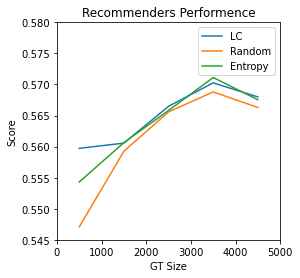

In [19]:
evaluator.plot(min_score=0.545, max_score=0.58, figsize=(4,4))

0.6901856760188041